In [0]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import os

import warnings
warnings.filterwarnings(action='ignore') 

from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
from tensorflow.keras import models
from tensorflow.keras import layers
from scipy.signal import savgol_filter

from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
_f = glob.glob('/content/drive/My Drive/daycon/*.csv')
_f

['/content/drive/My Drive/daycon/test.csv',
 '/content/drive/My Drive/daycon/train.csv',
 '/content/drive/My Drive/daycon/200412_hr_1.72.csv',
 '/content/drive/My Drive/daycon/200412_hr_1.21.csv',
 '/content/drive/My Drive/daycon/200412_hr_1.34.csv',
 '/content/drive/My Drive/daycon/200412_hr_1.00.csv',
 '/content/drive/My Drive/daycon/200412_hr_1.11.csv',
 '/content/drive/My Drive/daycon/200412_hr_0.65.csv',
 '/content/drive/My Drive/daycon/final_result_best.csv',
 '/content/drive/My Drive/daycon/200405_hr_2.19.csv',
 '/content/drive/My Drive/daycon/200413_hr_1.53.csv',
 '/content/drive/My Drive/daycon/200413_hr_1.51.csv',
 '/content/drive/My Drive/daycon/200413_hr_1.39.csv',
 '/content/drive/My Drive/daycon/200413_hr_1.32.csv']

In [0]:
train = pd.read_csv(_f[1])
test = pd.read_csv(_f[0])
bestmodel = pd.read_csv(_f[8])

In [0]:
# Y값 분할
Y00_17 = train.iloc[:,-19:-1]
Y18 = train.iloc[:,-1]

# train x 컬럼 생성

In [0]:
# 데이터 정리
t = train[["X00","X31","X07","X32","X28"]]# 기온
h = train[["X20","X12","X37","X30","X38"]]# 습도
w = train[["X18","X26","X03","X24","X22"]] # 풍속


# 파생 X값 생성
d = pd.DataFrame((9/5)*t.values-0.55*(1-h/100).values*((9/5)*t-26).values+32, columns=["DI01","DI02","DI03","DI04","DI05"])
at = pd.DataFrame((13.12 + 0.6215*t.values-11.37*(w**0.16).values+0.3965*(w**0.16).values*t.values),columns=["AT01","AT02","AT03","AT04","AT05"])
dewpoint = pd.DataFrame((243.12 *((17.62 * t.values /(243.12 + t.values)) + np.log(h.values / 100.0))) / (17.62-((17.62 * t.values /(243.12 + t.values)) + np.log(h.values/ 100.0))),columns=["DP01","DP02","DP03","DP04","DP05"])
vapor_pressure= pd.DataFrame(611* np.exp((17.27*t.values)/(237.7+t.values))/1000,columns=["VP01","VP02","VP03","VP04","VP05"])
times = pd.DataFrame(list(range(144))*33,columns=["Times"])

train_X=train.iloc[:,:41]
train_X


#실제 강수량
water=  train[["X04","X10","X21","X36","X39"]] #강수량

def water_diff(c):
    i=0
    diff_list=[]
    diff_list.append(water.loc[:0,c][0])
    for i in range(len(water)-1):        
        diff=(water.loc[i+1:i+1,c][i+1])-(water.loc[i:i,c][i])
        diff_list.append(round(diff,1))

    for i in range(len(diff_list)):
        if i % 144==0:
            diff_list[i]=0.0
    df=pd.DataFrame(diff_list)
    return df

train_X["diff_X04"]=water_diff("X04")
train_X["diff_X10"]=water_diff("X10")
train_X["diff_X21"]=water_diff("X21")
train_X["diff_X36"]=water_diff("X36")
train_X["diff_X39"]=water_diff("X39")


#실제 일조량
sun= train[["X11","X34","X14","X16","X19"]]

def sun_diff(c):
    i=0
    diff_list=[]
    diff_list.append(sun.loc[:0,c][0])
    for i in range(len(sun)-1):        
        diff=(sun.loc[i+1:i+1,c][i+1])-(sun.loc[i:i,c][i])
        diff_list.append(round(diff,1))
        
    for i in range(len(diff_list)):
        if i % 144==0:
            diff_list[i]=0.0
    df=pd.DataFrame(diff_list)
    return df

train_X["diff_X11"]=sun_diff("X11")
train_X["diff_X34"]=sun_diff("X34")
train_X["diff_X14"]=sun_diff("X14")
train_X["diff_X16"]=sun_diff("X16")
train_X["diff_X19"]=sun_diff("X19")

train = pd.concat([train_X.iloc[:,:51], d, at, dewpoint, vapor_pressure, times, train.iloc[:, 41:]], axis=1)


# test x 컬럼 생성

In [0]:
t = test[["X00","X31","X07","X32","X28"]]# 기온
h = test[["X20","X12","X37","X30","X38"]]# 습도
w = test[["X18","X26","X03","X24","X22"]] # 풍속

d = pd.DataFrame((9/5)*t.values-0.55*(1-h/100).values*((9/5)*t-26).values+32, columns=["DI01","DI02","DI03","DI04","DI05"])
at = pd.DataFrame((13.12 + 0.6215*t.values-11.37*(w**0.16).values+0.3965*(w**0.16).values*t.values),columns=["AT01","AT02","AT03","AT04","AT05"])
dewpoint = pd.DataFrame((243.12 *((17.62 * t.values /(243.12 + t.values)) + np.log(h.values / 100.0))) / (17.62-((17.62 * t.values /(243.12 + t.values)) + np.log(h.values/ 100.0))),columns=["DP01","DP02","DP03","DP04","DP05"])
vapor_pressure= pd.DataFrame(611* np.exp((17.27*t.values)/(237.7+t.values))/1000,columns=["VP01","VP02","VP03","VP04","VP05"])
times = pd.DataFrame(list(range(144))*80,columns=["Times"])

#실제 강수량
water_=  test[["X04","X10","X21","X36","X39"]] #강수량

def water_diff(c):
    i=0
    diff_list=[]
    diff_list.append(water_.loc[:0,c][0])
    for i in range(len(water_)-1):        
        diff=(water_.loc[i+1:i+1,c][i+1])-(water_.loc[i:i,c][i])
        diff_list.append(round(diff,1))
        
    for i in range(len(diff_list)):
        if i % 144==0:
            diff_list[i]=0.0
    df=pd.DataFrame(diff_list)
    return df

test["diff_X04"]=water_diff("X04")
test["diff_X10"]=water_diff("X10")
test["diff_X21"]=water_diff("X21")
test["diff_X36"]=water_diff("X36")
test["diff_X39"]=water_diff("X39")


#실제 일조량
sun_= test[["X11","X34","X14","X16","X19"]]

def sun_diff(c):
    i=0
    diff_list=[]
    diff_list.append(sun_.loc[:0,c][0])
    for i in range(len(sun_)-1):        
        diff=(sun_.loc[i+1:i+1,c][i+1])-(sun_.loc[i:i,c][i])
        diff_list.append(round(diff,1))
        
    for i in range(len(diff_list)):
        if i % 144==0:
            diff_list[i]=0.0
    df=pd.DataFrame(diff_list)
    return df


test["diff_X11"]=sun_diff("X11")
test["diff_X34"]=sun_diff("X34")
test["diff_X14"]=sun_diff("X14")
test["diff_X16"]=sun_diff("X16")
test["diff_X19"]=sun_diff("X19")

test = pd.concat([test, d, at, dewpoint, vapor_pressure, times], axis=1)

# 데이터 정리 (train, test)

In [0]:
train=train.drop(water, axis=1, inplace=False)
test=test.drop(water_, axis=1, inplace=False)

In [0]:
train=train.drop(sun, axis=1, inplace=False)
test=test.drop(sun_, axis=1, inplace=False)

In [0]:
train_set = train[:4320] #3일 전 값
test_set = train[4320:] #3일 값

# id 없애고 나머지 열만 남기기
train_set = train_set.iloc[:,1:-1].reset_index(drop=True)
test_set = test_set.iloc[:,1:-1].reset_index(drop=True)

In [0]:
# train_set과 test_set input data 와 target값으로 구분
train_data = train_set.iloc[:,:-18]
train_target = train_set.iloc[:,-18:]
test_data = test_set.iloc[:,:-18]
test_target = test_set.iloc[:,-18:]

r_df = pd.DataFrame({'id':range(4320,4752)})

# Y00~Y17 & train Y18 예측모델 생성

In [0]:
def build_model(train_data):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
    return model

# Y00~Y17 예측 데이터 생성

In [0]:
batch = 16
epoch = 80

In [0]:
r_df = pd.DataFrame({'id':range(4320,4752)})

with tqdm(total=len(test_target.columns)) as pbar:
    for i in test_target.columns :
        random.seed(777)
        np.random.seed(777)
        tf.random.set_seed(777)
        model = build_model(train_data)  
        model.fit(train_data, train_target[i],  # train데이터로 훈련
                  epochs=epoch, batch_size=batch, verbose=2)
        test_mse_score, test_mae_score = model.evaluate(test_data, test_target[i])

        # 마지막 노드 데이터 = 예측값을 가져와서 빈 데이터프레임에 합치기
        result = model.predict(test_data, batch_size=batch)
        r = pd.DataFrame(result)
        r.columns = [i+'_pre']
        r_df = r_df.join(r)
        pbar.update(1)


  0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1/80
270/270 - 0s - loss: 2315.7307 - mae: 31.8485
Epoch 2/80
270/270 - 0s - loss: 258.2616 - mae: 14.7672
Epoch 3/80
270/270 - 0s - loss: 42.9194 - mae: 5.3256
Epoch 4/80
270/270 - 0s - loss: 12.9795 - mae: 2.8706
Epoch 5/80
270/270 - 0s - loss: 9.1635 - mae: 2.4182
Epoch 6/80
270/270 - 0s - loss: 7.2369 - mae: 2.1272
Epoch 7/80
270/270 - 0s - loss: 6.0053 - mae: 1.9491
Epoch 8/80
270/270 - 0s - loss: 5.0673 - mae: 1.8296
Epoch 9/80
270/270 - 0s - loss: 4.3534 - mae: 1.6613
Epoch 10/80
270/270 - 0s - loss: 4.1290 - mae: 1.6400
Epoch 11/80
270/270 - 0s - loss: 3.6145 - mae: 1.5028
Epoch 12/80
270/270 - 0s - loss: 3.5906 - mae: 1.5072
Epoch 13/80
270/270 - 0s - loss: 3.2242 - mae: 1.4373
Epoch 14/80
270/270 - 0s - loss: 3.0428 - mae: 1.4071
Epoch 15/80
270/270 - 0s - loss: 3.0086 - mae: 1.3964
Epoch 16/80
270/270 - 0s - loss: 2.8531 - mae: 1.3487
Epoch 17/80
270/270 - 0s - loss: 2.7911 - mae: 1.3471
Epoch 18/80
270/270 - 0s - loss: 2.6387 - mae: 1.3107
Epoch 19/80
270/270 - 0s - l

  6%|▌         | 1/18 [00:27<07:46, 27.42s/it]

Epoch 1/80
270/270 - 0s - loss: 2320.3032 - mae: 31.8412
Epoch 2/80
270/270 - 0s - loss: 256.9862 - mae: 14.2223
Epoch 3/80
270/270 - 0s - loss: 49.9634 - mae: 5.7913
Epoch 4/80
270/270 - 0s - loss: 23.6200 - mae: 3.8822
Epoch 5/80
270/270 - 0s - loss: 16.8674 - mae: 3.2472
Epoch 6/80
270/270 - 0s - loss: 14.0309 - mae: 2.9799
Epoch 7/80
270/270 - 0s - loss: 11.5661 - mae: 2.7274
Epoch 8/80
270/270 - 0s - loss: 9.7409 - mae: 2.5076
Epoch 9/80
270/270 - 0s - loss: 8.6276 - mae: 2.3296
Epoch 10/80
270/270 - 0s - loss: 7.7642 - mae: 2.2219
Epoch 11/80
270/270 - 0s - loss: 7.0681 - mae: 2.1418
Epoch 12/80
270/270 - 0s - loss: 6.7555 - mae: 2.0687
Epoch 13/80
270/270 - 0s - loss: 6.3553 - mae: 1.9719
Epoch 14/80
270/270 - 0s - loss: 6.3516 - mae: 2.0122
Epoch 15/80
270/270 - 0s - loss: 5.7729 - mae: 1.9105
Epoch 16/80
270/270 - 0s - loss: 5.5309 - mae: 1.8645
Epoch 17/80
270/270 - 0s - loss: 5.3262 - mae: 1.8244
Epoch 18/80
270/270 - 0s - loss: 5.3018 - mae: 1.8298
Epoch 19/80
270/270 - 0s 

 11%|█         | 2/18 [00:53<07:13, 27.09s/it]

Epoch 1/80
270/270 - 0s - loss: 2302.6553 - mae: 31.2221
Epoch 2/80
270/270 - 0s - loss: 233.8820 - mae: 13.4794
Epoch 3/80
270/270 - 0s - loss: 49.8495 - mae: 5.6525
Epoch 4/80
270/270 - 0s - loss: 22.8445 - mae: 3.7971
Epoch 5/80
270/270 - 0s - loss: 15.9943 - mae: 3.1826
Epoch 6/80
270/270 - 0s - loss: 13.0908 - mae: 2.8921
Epoch 7/80
270/270 - 0s - loss: 10.8223 - mae: 2.6234
Epoch 8/80
270/270 - 0s - loss: 8.8822 - mae: 2.3867
Epoch 9/80
270/270 - 0s - loss: 7.8064 - mae: 2.2475
Epoch 10/80
270/270 - 0s - loss: 7.1167 - mae: 2.1194
Epoch 11/80
270/270 - 0s - loss: 6.4694 - mae: 2.0285
Epoch 12/80
270/270 - 0s - loss: 6.1231 - mae: 1.9739
Epoch 13/80
270/270 - 0s - loss: 5.8786 - mae: 1.9269
Epoch 14/80
270/270 - 0s - loss: 5.4652 - mae: 1.8493
Epoch 15/80
270/270 - 0s - loss: 5.3782 - mae: 1.8275
Epoch 16/80
270/270 - 0s - loss: 5.1083 - mae: 1.8174
Epoch 17/80
270/270 - 0s - loss: 4.9061 - mae: 1.7664
Epoch 18/80
270/270 - 0s - loss: 4.8881 - mae: 1.7680
Epoch 19/80
270/270 - 0s 

 17%|█▋        | 3/18 [01:22<06:51, 27.44s/it]

Epoch 1/80
270/270 - 0s - loss: 2298.4502 - mae: 31.9478
Epoch 2/80
270/270 - 0s - loss: 263.8438 - mae: 14.7824
Epoch 3/80
270/270 - 0s - loss: 44.3694 - mae: 5.2553
Epoch 4/80
270/270 - 0s - loss: 12.8759 - mae: 2.8339
Epoch 5/80
270/270 - 0s - loss: 9.5257 - mae: 2.4653
Epoch 6/80
270/270 - 0s - loss: 7.6435 - mae: 2.1991
Epoch 7/80
270/270 - 0s - loss: 6.6151 - mae: 2.0712
Epoch 8/80
270/270 - 0s - loss: 6.0730 - mae: 1.9725
Epoch 9/80
270/270 - 0s - loss: 5.7420 - mae: 1.9165
Epoch 10/80
270/270 - 0s - loss: 5.2853 - mae: 1.8382
Epoch 11/80
270/270 - 0s - loss: 4.9060 - mae: 1.7776
Epoch 12/80
270/270 - 0s - loss: 4.7961 - mae: 1.7618
Epoch 13/80
270/270 - 0s - loss: 4.6431 - mae: 1.7351
Epoch 14/80
270/270 - 0s - loss: 4.3965 - mae: 1.6840
Epoch 15/80
270/270 - 0s - loss: 4.2601 - mae: 1.6602
Epoch 16/80
270/270 - 0s - loss: 4.3473 - mae: 1.6788
Epoch 17/80
270/270 - 0s - loss: 4.1680 - mae: 1.6409
Epoch 18/80
270/270 - 0s - loss: 3.9878 - mae: 1.6070
Epoch 19/80
270/270 - 0s - l

 22%|██▏       | 4/18 [01:49<06:22, 27.36s/it]

Epoch 1/80
270/270 - 0s - loss: 2294.7571 - mae: 31.8957
Epoch 2/80
270/270 - 0s - loss: 258.3256 - mae: 14.5993
Epoch 3/80
270/270 - 0s - loss: 45.1912 - mae: 5.4405
Epoch 4/80
270/270 - 0s - loss: 13.2327 - mae: 2.9286
Epoch 5/80
270/270 - 0s - loss: 9.6934 - mae: 2.4893
Epoch 6/80
270/270 - 0s - loss: 7.9033 - mae: 2.2469
Epoch 7/80
270/270 - 0s - loss: 6.8230 - mae: 2.0954
Epoch 8/80
270/270 - 0s - loss: 6.2994 - mae: 2.0098
Epoch 9/80
270/270 - 0s - loss: 5.7393 - mae: 1.9125
Epoch 10/80
270/270 - 0s - loss: 5.5967 - mae: 1.9050
Epoch 11/80
270/270 - 0s - loss: 5.1812 - mae: 1.8210
Epoch 12/80
270/270 - 0s - loss: 5.1182 - mae: 1.8068
Epoch 13/80
270/270 - 0s - loss: 4.7762 - mae: 1.7650
Epoch 14/80
270/270 - 0s - loss: 4.3128 - mae: 1.6568
Epoch 15/80
270/270 - 0s - loss: 4.0494 - mae: 1.6100
Epoch 16/80
270/270 - 0s - loss: 3.6460 - mae: 1.5297
Epoch 17/80
270/270 - 0s - loss: 3.3162 - mae: 1.4454
Epoch 18/80
270/270 - 0s - loss: 2.9923 - mae: 1.3730
Epoch 19/80
270/270 - 0s - l

 28%|██▊       | 5/18 [02:16<05:54, 27.24s/it]

Epoch 1/80
270/270 - 0s - loss: 2331.2402 - mae: 31.1912
Epoch 2/80
270/270 - 0s - loss: 260.0505 - mae: 13.5251
Epoch 3/80
270/270 - 0s - loss: 69.2045 - mae: 6.6859
Epoch 4/80
270/270 - 0s - loss: 38.4107 - mae: 4.8295
Epoch 5/80
270/270 - 0s - loss: 30.4685 - mae: 4.2622
Epoch 6/80
270/270 - 0s - loss: 25.6067 - mae: 3.8381
Epoch 7/80
270/270 - 0s - loss: 22.6395 - mae: 3.6523
Epoch 8/80
270/270 - 0s - loss: 20.6563 - mae: 3.4804
Epoch 9/80
270/270 - 0s - loss: 19.1233 - mae: 3.2869
Epoch 10/80
270/270 - 0s - loss: 18.5995 - mae: 3.2842
Epoch 11/80
270/270 - 0s - loss: 17.3679 - mae: 3.1437
Epoch 12/80
270/270 - 0s - loss: 16.2994 - mae: 3.0387
Epoch 13/80
270/270 - 0s - loss: 15.6944 - mae: 2.9716
Epoch 14/80
270/270 - 0s - loss: 15.9008 - mae: 2.9680
Epoch 15/80
270/270 - 0s - loss: 15.1194 - mae: 2.8809
Epoch 16/80
270/270 - 0s - loss: 14.6598 - mae: 2.8119
Epoch 17/80
270/270 - 0s - loss: 13.8320 - mae: 2.7607
Epoch 18/80
270/270 - 0s - loss: 13.9179 - mae: 2.7461
Epoch 19/80
27

 33%|███▎      | 6/18 [02:43<05:25, 27.15s/it]

Epoch 1/80
270/270 - 0s - loss: 2345.4177 - mae: 31.3720
Epoch 2/80
270/270 - 0s - loss: 268.0805 - mae: 14.2329
Epoch 3/80
270/270 - 0s - loss: 70.8827 - mae: 6.6012
Epoch 4/80
270/270 - 0s - loss: 38.1360 - mae: 4.8700
Epoch 5/80
270/270 - 0s - loss: 27.5275 - mae: 4.0882
Epoch 6/80
270/270 - 0s - loss: 23.2739 - mae: 3.7467
Epoch 7/80
270/270 - 0s - loss: 18.8354 - mae: 3.3587
Epoch 8/80
270/270 - 0s - loss: 17.7574 - mae: 3.2955
Epoch 9/80
270/270 - 0s - loss: 15.4868 - mae: 3.0272
Epoch 10/80
270/270 - 0s - loss: 14.3496 - mae: 2.9006
Epoch 11/80
270/270 - 0s - loss: 13.5452 - mae: 2.8443
Epoch 12/80
270/270 - 0s - loss: 12.0041 - mae: 2.6742
Epoch 13/80
270/270 - 0s - loss: 11.5069 - mae: 2.6192
Epoch 14/80
270/270 - 0s - loss: 10.7297 - mae: 2.5056
Epoch 15/80
270/270 - 0s - loss: 10.2720 - mae: 2.4748
Epoch 16/80
270/270 - 0s - loss: 9.5434 - mae: 2.3611
Epoch 17/80
270/270 - 0s - loss: 9.4294 - mae: 2.3822
Epoch 18/80
270/270 - 0s - loss: 8.9706 - mae: 2.2877
Epoch 19/80
270/2

 39%|███▉      | 7/18 [03:09<04:57, 27.02s/it]

Epoch 1/80
270/270 - 0s - loss: 2291.7808 - mae: 30.1883
Epoch 2/80
270/270 - 0s - loss: 209.0289 - mae: 11.7662
Epoch 3/80
270/270 - 0s - loss: 74.5120 - mae: 6.7765
Epoch 4/80
270/270 - 0s - loss: 50.8345 - mae: 5.3250
Epoch 5/80
270/270 - 0s - loss: 40.8723 - mae: 4.7363
Epoch 6/80
270/270 - 0s - loss: 36.9956 - mae: 4.4854
Epoch 7/80
270/270 - 0s - loss: 32.1248 - mae: 4.1612
Epoch 8/80
270/270 - 0s - loss: 29.6329 - mae: 3.9902
Epoch 9/80
270/270 - 0s - loss: 26.0466 - mae: 3.7839
Epoch 10/80
270/270 - 0s - loss: 22.9923 - mae: 3.5351
Epoch 11/80
270/270 - 0s - loss: 21.2841 - mae: 3.4468
Epoch 12/80
270/270 - 0s - loss: 19.7065 - mae: 3.2581
Epoch 13/80
270/270 - 0s - loss: 18.8211 - mae: 3.2332
Epoch 14/80
270/270 - 0s - loss: 18.2661 - mae: 3.1774
Epoch 15/80
270/270 - 0s - loss: 16.9576 - mae: 3.0170
Epoch 16/80
270/270 - 0s - loss: 16.5110 - mae: 2.9630
Epoch 17/80
270/270 - 0s - loss: 15.8677 - mae: 2.9440
Epoch 18/80
270/270 - 0s - loss: 15.3008 - mae: 2.8243
Epoch 19/80
27

 44%|████▍     | 8/18 [03:36<04:30, 27.07s/it]

Epoch 1/80
270/270 - 0s - loss: 2350.9250 - mae: 31.3374
Epoch 2/80
270/270 - 0s - loss: 269.9207 - mae: 13.9514
Epoch 3/80
270/270 - 0s - loss: 85.4367 - mae: 7.3591
Epoch 4/80
270/270 - 0s - loss: 45.5223 - mae: 5.1781
Epoch 5/80
270/270 - 0s - loss: 33.9743 - mae: 4.3820
Epoch 6/80
270/270 - 0s - loss: 30.5168 - mae: 4.1482
Epoch 7/80
270/270 - 0s - loss: 27.3906 - mae: 3.9101
Epoch 8/80
270/270 - 0s - loss: 25.3514 - mae: 3.7477
Epoch 9/80
270/270 - 0s - loss: 23.4726 - mae: 3.5893
Epoch 10/80
270/270 - 0s - loss: 22.5451 - mae: 3.4769
Epoch 11/80
270/270 - 0s - loss: 21.1859 - mae: 3.3504
Epoch 12/80
270/270 - 0s - loss: 20.3919 - mae: 3.2944
Epoch 13/80
270/270 - 0s - loss: 19.4693 - mae: 3.1841
Epoch 14/80
270/270 - 0s - loss: 19.2401 - mae: 3.1893
Epoch 15/80
270/270 - 0s - loss: 18.7428 - mae: 3.1122
Epoch 16/80
270/270 - 0s - loss: 18.5694 - mae: 3.0589
Epoch 17/80
270/270 - 0s - loss: 17.7231 - mae: 3.0660
Epoch 18/80
270/270 - 0s - loss: 18.1374 - mae: 3.0604
Epoch 19/80
27

 50%|█████     | 9/18 [04:04<04:04, 27.13s/it]

Epoch 1/80
270/270 - 0s - loss: 2341.1030 - mae: 31.2623
Epoch 2/80
270/270 - 0s - loss: 250.3264 - mae: 13.2315
Epoch 3/80
270/270 - 0s - loss: 72.4157 - mae: 6.7163
Epoch 4/80
270/270 - 0s - loss: 38.2556 - mae: 4.9712
Epoch 5/80
270/270 - 0s - loss: 26.2570 - mae: 4.0231
Epoch 6/80
270/270 - 0s - loss: 22.0105 - mae: 3.6691
Epoch 7/80
270/270 - 0s - loss: 18.0322 - mae: 3.3709
Epoch 8/80
270/270 - 0s - loss: 15.8784 - mae: 3.1376
Epoch 9/80
270/270 - 0s - loss: 13.8769 - mae: 2.8963
Epoch 10/80
270/270 - 0s - loss: 12.3969 - mae: 2.7687
Epoch 11/80
270/270 - 0s - loss: 11.6293 - mae: 2.6889
Epoch 12/80
270/270 - 0s - loss: 10.3849 - mae: 2.5497
Epoch 13/80
270/270 - 0s - loss: 10.0163 - mae: 2.5037
Epoch 14/80
270/270 - 0s - loss: 9.6841 - mae: 2.4291
Epoch 15/80
270/270 - 0s - loss: 9.5360 - mae: 2.4285
Epoch 16/80
270/270 - 0s - loss: 8.8306 - mae: 2.2843
Epoch 17/80
270/270 - 0s - loss: 8.1978 - mae: 2.2269
Epoch 18/80
270/270 - 0s - loss: 7.9333 - mae: 2.2065
Epoch 19/80
270/270

 56%|█████▌    | 10/18 [04:31<03:36, 27.12s/it]

Epoch 1/80
270/270 - 0s - loss: 2295.6316 - mae: 30.4769
Epoch 2/80
270/270 - 0s - loss: 225.9434 - mae: 12.4086
Epoch 3/80
270/270 - 0s - loss: 74.9803 - mae: 6.8743
Epoch 4/80
270/270 - 0s - loss: 42.9266 - mae: 5.1730
Epoch 5/80
270/270 - 0s - loss: 32.8309 - mae: 4.4834
Epoch 6/80
270/270 - 0s - loss: 27.1549 - mae: 4.1045
Epoch 7/80
270/270 - 0s - loss: 22.8445 - mae: 3.7451
Epoch 8/80
270/270 - 0s - loss: 20.3204 - mae: 3.5043
Epoch 9/80
270/270 - 0s - loss: 18.5197 - mae: 3.3268
Epoch 10/80
270/270 - 0s - loss: 17.3995 - mae: 3.2626
Epoch 11/80
270/270 - 0s - loss: 15.4182 - mae: 3.0184
Epoch 12/80
270/270 - 0s - loss: 14.2165 - mae: 2.9022
Epoch 13/80
270/270 - 0s - loss: 13.6547 - mae: 2.8651
Epoch 14/80
270/270 - 0s - loss: 13.0468 - mae: 2.7977
Epoch 15/80
270/270 - 0s - loss: 12.7578 - mae: 2.7131
Epoch 16/80
270/270 - 0s - loss: 11.7841 - mae: 2.6028
Epoch 17/80
270/270 - 0s - loss: 11.1284 - mae: 2.5375
Epoch 18/80
270/270 - 0s - loss: 10.9894 - mae: 2.5404
Epoch 19/80
27

 61%|██████    | 11/18 [04:58<03:09, 27.02s/it]

Epoch 1/80
270/270 - 0s - loss: 2288.2927 - mae: 30.1820
Epoch 2/80
270/270 - 0s - loss: 214.6302 - mae: 11.9978
Epoch 3/80
270/270 - 0s - loss: 89.7656 - mae: 7.6505
Epoch 4/80
270/270 - 0s - loss: 55.9744 - mae: 5.9019
Epoch 5/80
270/270 - 0s - loss: 41.9404 - mae: 5.0673
Epoch 6/80
270/270 - 0s - loss: 34.8611 - mae: 4.6165
Epoch 7/80
270/270 - 0s - loss: 29.3781 - mae: 4.2055
Epoch 8/80
270/270 - 0s - loss: 27.0723 - mae: 4.0185
Epoch 9/80
270/270 - 0s - loss: 24.6757 - mae: 3.8304
Epoch 10/80
270/270 - 0s - loss: 23.0550 - mae: 3.7328
Epoch 11/80
270/270 - 0s - loss: 20.9161 - mae: 3.5283
Epoch 12/80
270/270 - 0s - loss: 19.0264 - mae: 3.3238
Epoch 13/80
270/270 - 0s - loss: 18.4122 - mae: 3.2724
Epoch 14/80
270/270 - 0s - loss: 18.2333 - mae: 3.2796
Epoch 15/80
270/270 - 0s - loss: 18.1913 - mae: 3.2397
Epoch 16/80
270/270 - 0s - loss: 16.4311 - mae: 3.0406
Epoch 17/80
270/270 - 0s - loss: 15.6203 - mae: 2.9573
Epoch 18/80
270/270 - 0s - loss: 15.7742 - mae: 3.0090
Epoch 19/80
27

 67%|██████▋   | 12/18 [05:25<02:41, 26.99s/it]

Epoch 1/80
270/270 - 0s - loss: 2279.7300 - mae: 30.0146
Epoch 2/80
270/270 - 0s - loss: 195.7780 - mae: 11.4308
Epoch 3/80
270/270 - 0s - loss: 72.9178 - mae: 6.8729
Epoch 4/80
270/270 - 0s - loss: 43.6156 - mae: 5.2486
Epoch 5/80
270/270 - 0s - loss: 33.4132 - mae: 4.5641
Epoch 6/80
270/270 - 0s - loss: 29.0118 - mae: 4.2395
Epoch 7/80
270/270 - 0s - loss: 24.8773 - mae: 3.9081
Epoch 8/80
270/270 - 0s - loss: 21.9017 - mae: 3.6590
Epoch 9/80
270/270 - 0s - loss: 19.5110 - mae: 3.4543
Epoch 10/80
270/270 - 0s - loss: 18.0260 - mae: 3.2993
Epoch 11/80
270/270 - 0s - loss: 16.7432 - mae: 3.2043
Epoch 12/80
270/270 - 0s - loss: 15.0889 - mae: 3.0451
Epoch 13/80
270/270 - 0s - loss: 14.3031 - mae: 2.9453
Epoch 14/80
270/270 - 0s - loss: 13.2426 - mae: 2.8447
Epoch 15/80
270/270 - 0s - loss: 13.2749 - mae: 2.8592
Epoch 16/80
270/270 - 0s - loss: 12.5200 - mae: 2.7601
Epoch 17/80
270/270 - 0s - loss: 11.6204 - mae: 2.6898
Epoch 18/80
270/270 - 0s - loss: 11.5055 - mae: 2.6550
Epoch 19/80
27

 72%|███████▏  | 13/18 [05:51<02:14, 26.93s/it]

Epoch 1/80
270/270 - 0s - loss: 2332.9758 - mae: 31.8284
Epoch 2/80
270/270 - 0s - loss: 270.3661 - mae: 14.3734
Epoch 3/80
270/270 - 0s - loss: 56.9398 - mae: 6.0518
Epoch 4/80
270/270 - 0s - loss: 20.4259 - mae: 3.5891
Epoch 5/80
270/270 - 0s - loss: 14.3293 - mae: 2.9447
Epoch 6/80
270/270 - 0s - loss: 11.7411 - mae: 2.7227
Epoch 7/80
270/270 - 0s - loss: 9.6486 - mae: 2.4571
Epoch 8/80
270/270 - 0s - loss: 8.3088 - mae: 2.2819
Epoch 9/80
270/270 - 0s - loss: 7.1004 - mae: 2.1348
Epoch 10/80
270/270 - 0s - loss: 6.7025 - mae: 2.0315
Epoch 11/80
270/270 - 0s - loss: 6.0580 - mae: 1.9301
Epoch 12/80
270/270 - 0s - loss: 5.6073 - mae: 1.8609
Epoch 13/80
270/270 - 0s - loss: 5.5566 - mae: 1.8790
Epoch 14/80
270/270 - 0s - loss: 5.1721 - mae: 1.7958
Epoch 15/80
270/270 - 0s - loss: 5.0494 - mae: 1.7548
Epoch 16/80
270/270 - 0s - loss: 4.7695 - mae: 1.7169
Epoch 17/80
270/270 - 0s - loss: 4.5260 - mae: 1.6634
Epoch 18/80
270/270 - 0s - loss: 4.4960 - mae: 1.6621
Epoch 19/80
270/270 - 0s -

 78%|███████▊  | 14/18 [06:19<01:48, 27.19s/it]

Epoch 1/80
270/270 - 0s - loss: 2331.5330 - mae: 31.8490
Epoch 2/80
270/270 - 0s - loss: 249.7778 - mae: 13.6081
Epoch 3/80
270/270 - 0s - loss: 60.4174 - mae: 6.1048
Epoch 4/80
270/270 - 0s - loss: 25.7854 - mae: 3.9597
Epoch 5/80
270/270 - 0s - loss: 18.5379 - mae: 3.2893
Epoch 6/80
270/270 - 0s - loss: 15.0749 - mae: 2.9871
Epoch 7/80
270/270 - 0s - loss: 13.3758 - mae: 2.8234
Epoch 8/80
270/270 - 0s - loss: 12.0925 - mae: 2.6414
Epoch 9/80
270/270 - 0s - loss: 11.3020 - mae: 2.5647
Epoch 10/80
270/270 - 0s - loss: 10.5583 - mae: 2.4696
Epoch 11/80
270/270 - 0s - loss: 9.6549 - mae: 2.3368
Epoch 12/80
270/270 - 0s - loss: 9.5454 - mae: 2.2987
Epoch 13/80
270/270 - 0s - loss: 8.5799 - mae: 2.1995
Epoch 14/80
270/270 - 0s - loss: 8.6973 - mae: 2.2266
Epoch 15/80
270/270 - 0s - loss: 7.9897 - mae: 2.1098
Epoch 16/80
270/270 - 0s - loss: 7.8224 - mae: 2.0877
Epoch 17/80
270/270 - 0s - loss: 7.3684 - mae: 2.0385
Epoch 18/80
270/270 - 0s - loss: 7.5389 - mae: 2.0008
Epoch 19/80
270/270 - 

 83%|████████▎ | 15/18 [06:46<01:21, 27.24s/it]

Epoch 1/80
270/270 - 0s - loss: 2329.2595 - mae: 31.5955
Epoch 2/80
270/270 - 0s - loss: 237.2924 - mae: 13.4635
Epoch 3/80
270/270 - 0s - loss: 57.0646 - mae: 6.0347
Epoch 4/80
270/270 - 0s - loss: 27.4088 - mae: 4.1778
Epoch 5/80
270/270 - 0s - loss: 19.2655 - mae: 3.4732
Epoch 6/80
270/270 - 0s - loss: 14.9101 - mae: 3.0324
Epoch 7/80
270/270 - 0s - loss: 12.8204 - mae: 2.8009
Epoch 8/80
270/270 - 0s - loss: 10.9712 - mae: 2.6143
Epoch 9/80
270/270 - 0s - loss: 9.6761 - mae: 2.4444
Epoch 10/80
270/270 - 0s - loss: 8.6708 - mae: 2.2864
Epoch 11/80
270/270 - 0s - loss: 8.4009 - mae: 2.2695
Epoch 12/80
270/270 - 0s - loss: 8.2063 - mae: 2.2441
Epoch 13/80
270/270 - 0s - loss: 7.4455 - mae: 2.1597
Epoch 14/80
270/270 - 0s - loss: 7.3305 - mae: 2.1001
Epoch 15/80
270/270 - 0s - loss: 6.9695 - mae: 2.0817
Epoch 16/80
270/270 - 0s - loss: 6.6890 - mae: 2.0108
Epoch 17/80
270/270 - 0s - loss: 6.3284 - mae: 1.9629
Epoch 18/80
270/270 - 0s - loss: 6.3397 - mae: 1.9504
Epoch 19/80
270/270 - 0s

 89%|████████▉ | 16/18 [07:14<00:54, 27.47s/it]

Epoch 1/80
270/270 - 0s - loss: 2329.7627 - mae: 31.4418
Epoch 2/80
270/270 - 0s - loss: 269.9660 - mae: 14.3005
Epoch 3/80
270/270 - 0s - loss: 64.1411 - mae: 6.4470
Epoch 4/80
270/270 - 0s - loss: 34.6055 - mae: 4.7455
Epoch 5/80
270/270 - 0s - loss: 23.9282 - mae: 3.9190
Epoch 6/80
270/270 - 0s - loss: 19.2687 - mae: 3.4978
Epoch 7/80
270/270 - 0s - loss: 16.2684 - mae: 3.2072
Epoch 8/80
270/270 - 0s - loss: 14.1760 - mae: 3.0001
Epoch 9/80
270/270 - 0s - loss: 12.7403 - mae: 2.8256
Epoch 10/80
270/270 - 0s - loss: 11.5180 - mae: 2.6544
Epoch 11/80
270/270 - 0s - loss: 10.4921 - mae: 2.5676
Epoch 12/80
270/270 - 0s - loss: 9.5845 - mae: 2.4315
Epoch 13/80
270/270 - 0s - loss: 9.3689 - mae: 2.4361
Epoch 14/80
270/270 - 0s - loss: 8.5260 - mae: 2.3035
Epoch 15/80
270/270 - 0s - loss: 8.5560 - mae: 2.2996
Epoch 16/80
270/270 - 0s - loss: 7.8961 - mae: 2.2320
Epoch 17/80
270/270 - 0s - loss: 7.5856 - mae: 2.1912
Epoch 18/80
270/270 - 0s - loss: 7.3237 - mae: 2.1602
Epoch 19/80
270/270 -

 94%|█████████▍| 17/18 [07:42<00:27, 27.53s/it]

Epoch 1/80
270/270 - 0s - loss: 2350.0605 - mae: 31.4761
Epoch 2/80
270/270 - 0s - loss: 282.4012 - mae: 13.7481
Epoch 3/80
270/270 - 0s - loss: 86.6505 - mae: 7.5202
Epoch 4/80
270/270 - 0s - loss: 43.8955 - mae: 5.2243
Epoch 5/80
270/270 - 0s - loss: 31.4814 - mae: 4.3541
Epoch 6/80
270/270 - 0s - loss: 26.4031 - mae: 4.0186
Epoch 7/80
270/270 - 0s - loss: 22.0811 - mae: 3.6448
Epoch 8/80
270/270 - 0s - loss: 20.0552 - mae: 3.4316
Epoch 9/80
270/270 - 0s - loss: 17.5523 - mae: 3.2325
Epoch 10/80
270/270 - 0s - loss: 16.5905 - mae: 3.1273
Epoch 11/80
270/270 - 0s - loss: 15.5858 - mae: 3.0265
Epoch 12/80
270/270 - 0s - loss: 14.6480 - mae: 2.9002
Epoch 13/80
270/270 - 0s - loss: 13.4001 - mae: 2.7877
Epoch 14/80
270/270 - 0s - loss: 12.6754 - mae: 2.7123
Epoch 15/80
270/270 - 0s - loss: 12.8321 - mae: 2.6944
Epoch 16/80
270/270 - 0s - loss: 11.9028 - mae: 2.6064
Epoch 17/80
270/270 - 0s - loss: 11.2670 - mae: 2.4993
Epoch 18/80
270/270 - 0s - loss: 11.0489 - mae: 2.4962
Epoch 19/80
27

100%|██████████| 18/18 [08:09<00:00, 27.22s/it]


# train Y18 예측 데이터 생성

## train, test 데이터 생성

In [0]:
Y_traindata = r_df.iloc[:,16:18]
Y_traintarget = Y18.loc[4320:]
Y_traintarget = Y_traintarget.reset_index(drop=True)
Y_testdata = Y00_17[['Y15','Y16']].loc[:4319]
Y_testtarget = train['Y18'].loc[:4319]

## train Y18 예측 모델 학습 및 데이터 생성

In [0]:
batch = 16
epoch = 200

In [0]:
random.seed(777)
np.random.seed(777)
tf.random.set_seed(777)

Ymodel = build_model(Y_traindata)
Ymodel.fit(Y_traindata, Y_traintarget,
          epochs=epoch, batch_size=batch, verbose=2)
test_mse_score, test_mae_score = Ymodel.evaluate(Y_testdata, Y_testtarget)
result = Ymodel.predict(Y_testdata, batch_size=batch)

Epoch 1/200
27/27 - 0s - loss: 54.5529 - mae: 5.0835
Epoch 2/200
27/27 - 0s - loss: 5.0271 - mae: 1.7391
Epoch 3/200
27/27 - 0s - loss: 5.1996 - mae: 1.7198
Epoch 4/200
27/27 - 0s - loss: 5.1185 - mae: 1.7493
Epoch 5/200
27/27 - 0s - loss: 5.0091 - mae: 1.6963
Epoch 6/200
27/27 - 0s - loss: 4.9022 - mae: 1.6673
Epoch 7/200
27/27 - 0s - loss: 4.6817 - mae: 1.6359
Epoch 8/200
27/27 - 0s - loss: 4.2875 - mae: 1.5619
Epoch 9/200
27/27 - 0s - loss: 4.3648 - mae: 1.5717
Epoch 10/200
27/27 - 0s - loss: 4.4709 - mae: 1.5574
Epoch 11/200
27/27 - 0s - loss: 4.2914 - mae: 1.5920
Epoch 12/200
27/27 - 0s - loss: 4.2644 - mae: 1.5237
Epoch 13/200
27/27 - 0s - loss: 4.0933 - mae: 1.4917
Epoch 14/200
27/27 - 0s - loss: 4.1280 - mae: 1.5132
Epoch 15/200
27/27 - 0s - loss: 4.2649 - mae: 1.5489
Epoch 16/200
27/27 - 0s - loss: 3.9186 - mae: 1.4843
Epoch 17/200
27/27 - 0s - loss: 4.1591 - mae: 1.5234
Epoch 18/200
27/27 - 0s - loss: 3.8863 - mae: 1.4498
Epoch 19/200
27/27 - 0s - loss: 4.0740 - mae: 1.4822
E

In [0]:
# r2 : Y18 예측 데이터 프레임
r2 = pd.DataFrame(result)
r2.columns = ['Y18']

# test Y18 예측용 데이터 정리

In [0]:
new_Y18 = pd.DataFrame(train['Y18'].loc[4320:])
new_Y18 = pd.concat([r2,new_Y18])

new_Ys = pd.DataFrame(Y00_17.loc[:4319])
r_df2 = r_df.drop('id', axis =1)
r_df2.columns = new_Ys.columns
new_Ys = pd.concat([new_Ys, r_df2])

new_Ys = new_Ys.reset_index(drop=True)

newY = new_Ys.join(new_Y18)
X = pd.DataFrame(train.iloc[:,:-19])
new = X.join(newY)

newX = pd.DataFrame(new.iloc[:,:-19])

train_data = newX.drop('id',axis=1)
train_target = pd.DataFrame(new.iloc[:,-1])
test_data = test.drop('id',axis=1)
test_target = pd.DataFrame(index = range(0,11520),columns=['Y18'])

df = pd.DataFrame({'id':range(0,11520)})

In [0]:
train_data.shape

(4752, 61)

In [0]:
test_data.shape

(11520, 61)

# train Y18 예측 모델 생성

In [0]:
def build_model(train_data):
    model = models.Sequential()
    model.add(layers.Dense(1024,
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation = 'relu'))
    model.add(layers.Dense(128, activation = 'relu'))
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(32, activation = 'relu'))
    model.add(layers.Dense(16, activation = 'relu'))
    model.add(layers.Dense(8, activation = 'relu'))
    # model.add(layers.Dense(4, activation = 'relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
    return model

In [0]:
def build_model(train_data):
    model = models.Sequential()
    model.add(layers.LSTM(1024,
                           input_shape=(train_data.shape[1],)))
    model.add(layers.LSTM(512, return_sequences=True))
    model.add(layers.LSTM(256, activation = 'relu'))
    model.add(layers.LSTM(128, activation = 'relu'))
    model.add(layers.LSTM(64, activation = 'relu'))
    model.add(layers.LSTM(32, activation = 'relu'))
    model.add(layers.LSTM(16, activation = 'relu'))
    model.add(layers.LSTM(8, activation = 'relu'))
    model.add(layers.LSTM(1))
    model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
    return model

In [0]:
random.seed(777)
np.random.seed(777)
tf.random.set_seed(777)

model = build_model(train_data)

## 모델학습

In [0]:
epoch = 400
batch = 15

In [0]:
earlystopper = EarlyStopping(monitor="loss", patience=30, mode="min", verbose=2) 
modelcheck_p = ModelCheckpoint("best_model", monitor="loss", mode="min", save_best_only=True) 

In [0]:
t_df = df.copy()

random.seed(777)
np.random.seed(777)
tf.random.set_seed(777)
model.fit(train_data, train_target, epochs=epoch, batch_size=batch, verbose=2,
          callbacks=[earlystopper, modelcheck_p])

Epoch 1/400
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: best_model/assets
317/317 - 4s - loss: 314.0589 - mae: 10.0190
Epoch 2/400
INFO:tensorflow:Assets written to: best_model/assets
317/317 - 3s - loss: 42.1439 - mae: 5.1022
Epoch 3/400
INFO:tensorflow:Assets written to: best_model/assets
317/317 - 4s - loss: 31.4865 - mae: 4.3697
Epoch 4/400
INFO:tensorflow:Assets written to: best_model/assets
317/317 - 3s - loss: 24.7047 - mae: 3.9054
Epoch 5/400
INFO:tensorflow:Assets written to: best_model/assets
317/317 - 4s - loss: 21.9487 - mae: 3.6743
Epoch 6/400
INFO:tensorflow:Assets written to: best_model/assets
317/317 - 4s - loss: 19.6624 - mae: 3.4552
Epoch 7/400
INFO:tensorflow:Assets written to: best_model/assets
317/317 - 4s - loss: 17.9512 - mae: 3.3407
Epoch 8/400
INFO:tensorflow:Assets written to: best_model/assets
317/317 - 4s - loss: 16.7604 - mae: 3.2261
Epoch 9/400
INFO:tensorflow:Assets written to: best_m

## 예측 데이터 생성

In [0]:
model=load_model("best_model")
random.seed(777)
np.random.seed(777)
tf.random.set_seed(777)
result = model.predict(test_data, batch_size=batch)
r3 = pd.DataFrame(result)
r3.columns = ['Y18_pre']
t_df = t_df.join(r3)

save = pd.DataFrame(t_df['Y18_pre'])
save.columns = ['Y18']
save.index = test['id']

# best model과 비교

In [0]:
def mse_AIFrenz(y_true, y_pred):
    '''
    y_true: 실제 값
    y_pred: 예측 값
    '''
    diff = abs(y_true - y_pred)
    
    less_then_one = np.where(diff < 1, 0, diff)
    
    # multi-column일 경우에도 계산 할 수 있도록 np.average를 한번 더 씌움
    score = np.average(np.average(less_then_one ** 2, axis = 0))
    
    return score

In [0]:
# 필터 적용 전

score = mse_AIFrenz(bestmodel.Y18,save.reset_index(drop=True).Y18)
total_score = 1.4968490671 + score

print("Best model과 차이 : {}".format(score))
print('예상점수 : {}'.format(total_score))

Best model과 차이 : 1.428710068593335
예상점수 : 2.925559135693335


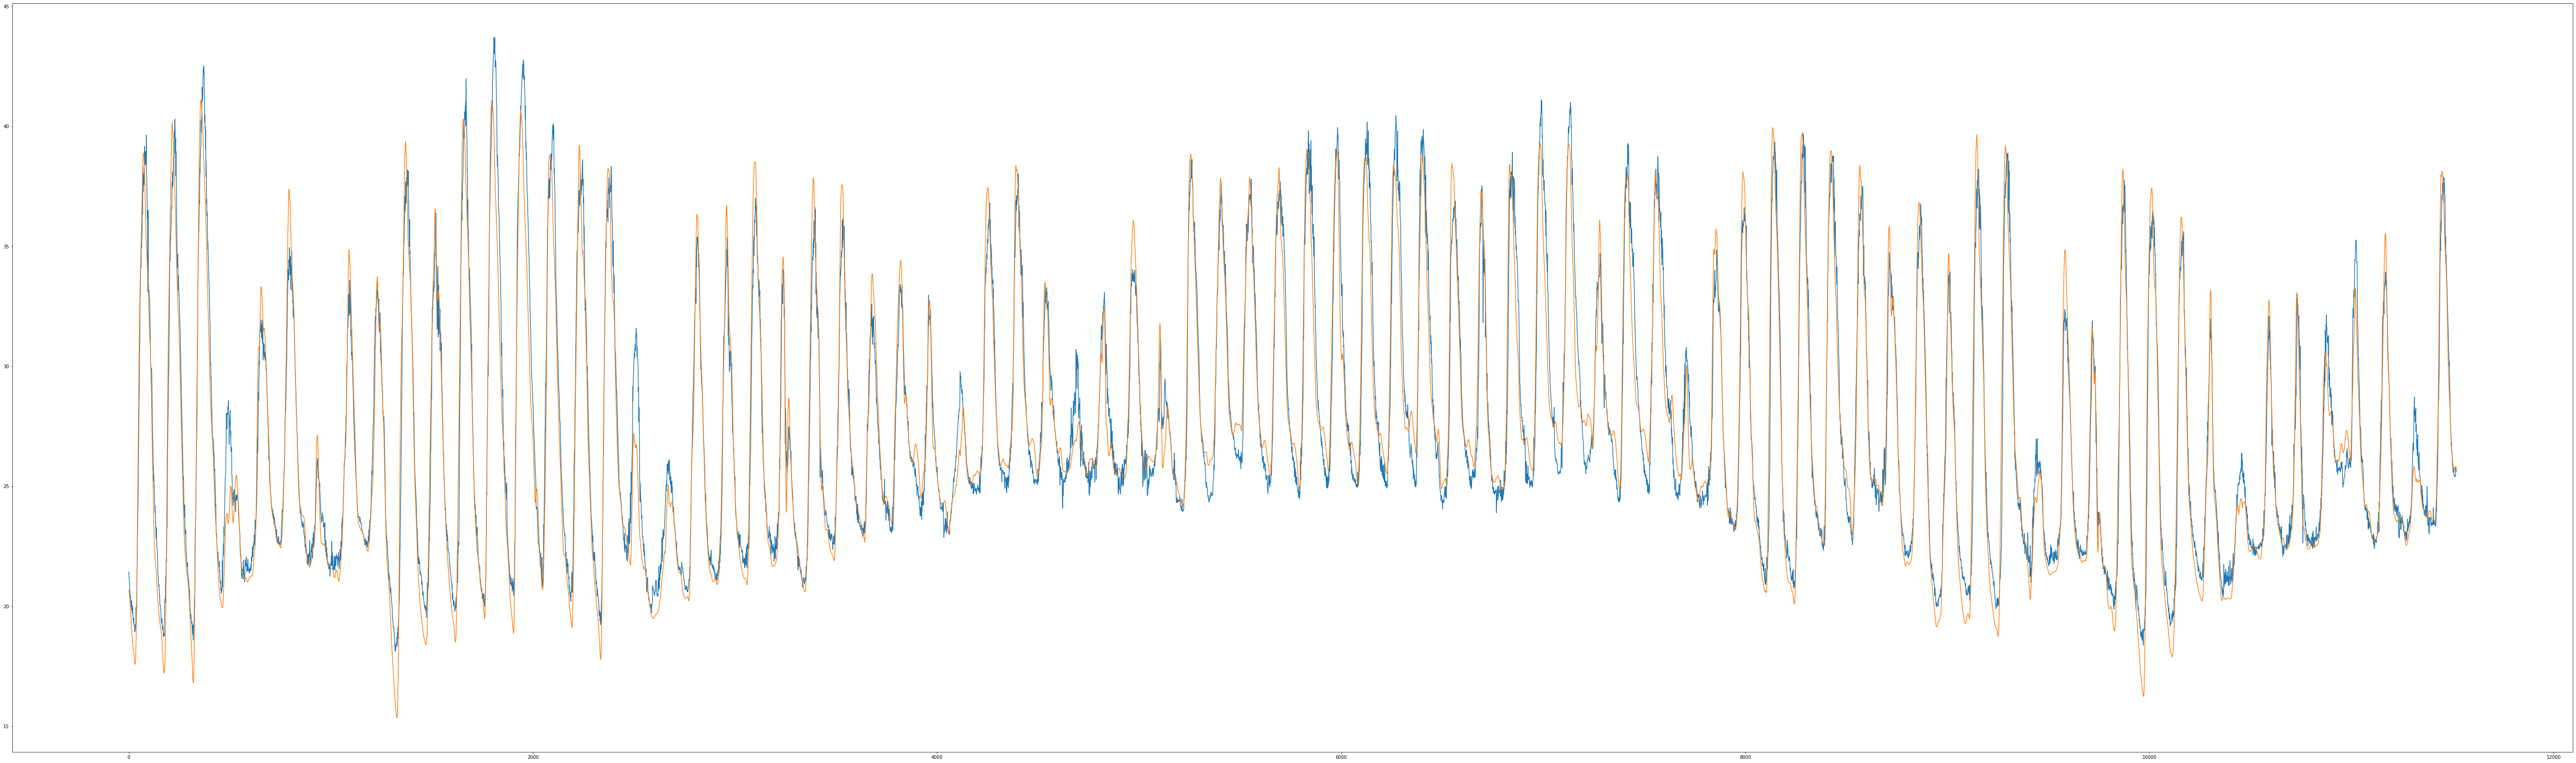

In [0]:
# 필터 적용 전 그래프

plt.figure(figsize=(100,30))
plt.plot(save.reset_index().iloc[:,-1:])
plt.plot(bestmodel.iloc[:,-1:])

In [0]:
# 필터 적용 후

c = save.copy()

filtered = savgol_filter(c['Y18'], 21, 3)
score = mse_AIFrenz(bestmodel.Y18,filtered)
total_score = 1.4968490671 + score

print("Best model과 차이 : {}".format(score))
print('예상점수 : {}'.format(total_score))

Best model과 차이 : 1.325597184540767
예상점수 : 2.822446251640767


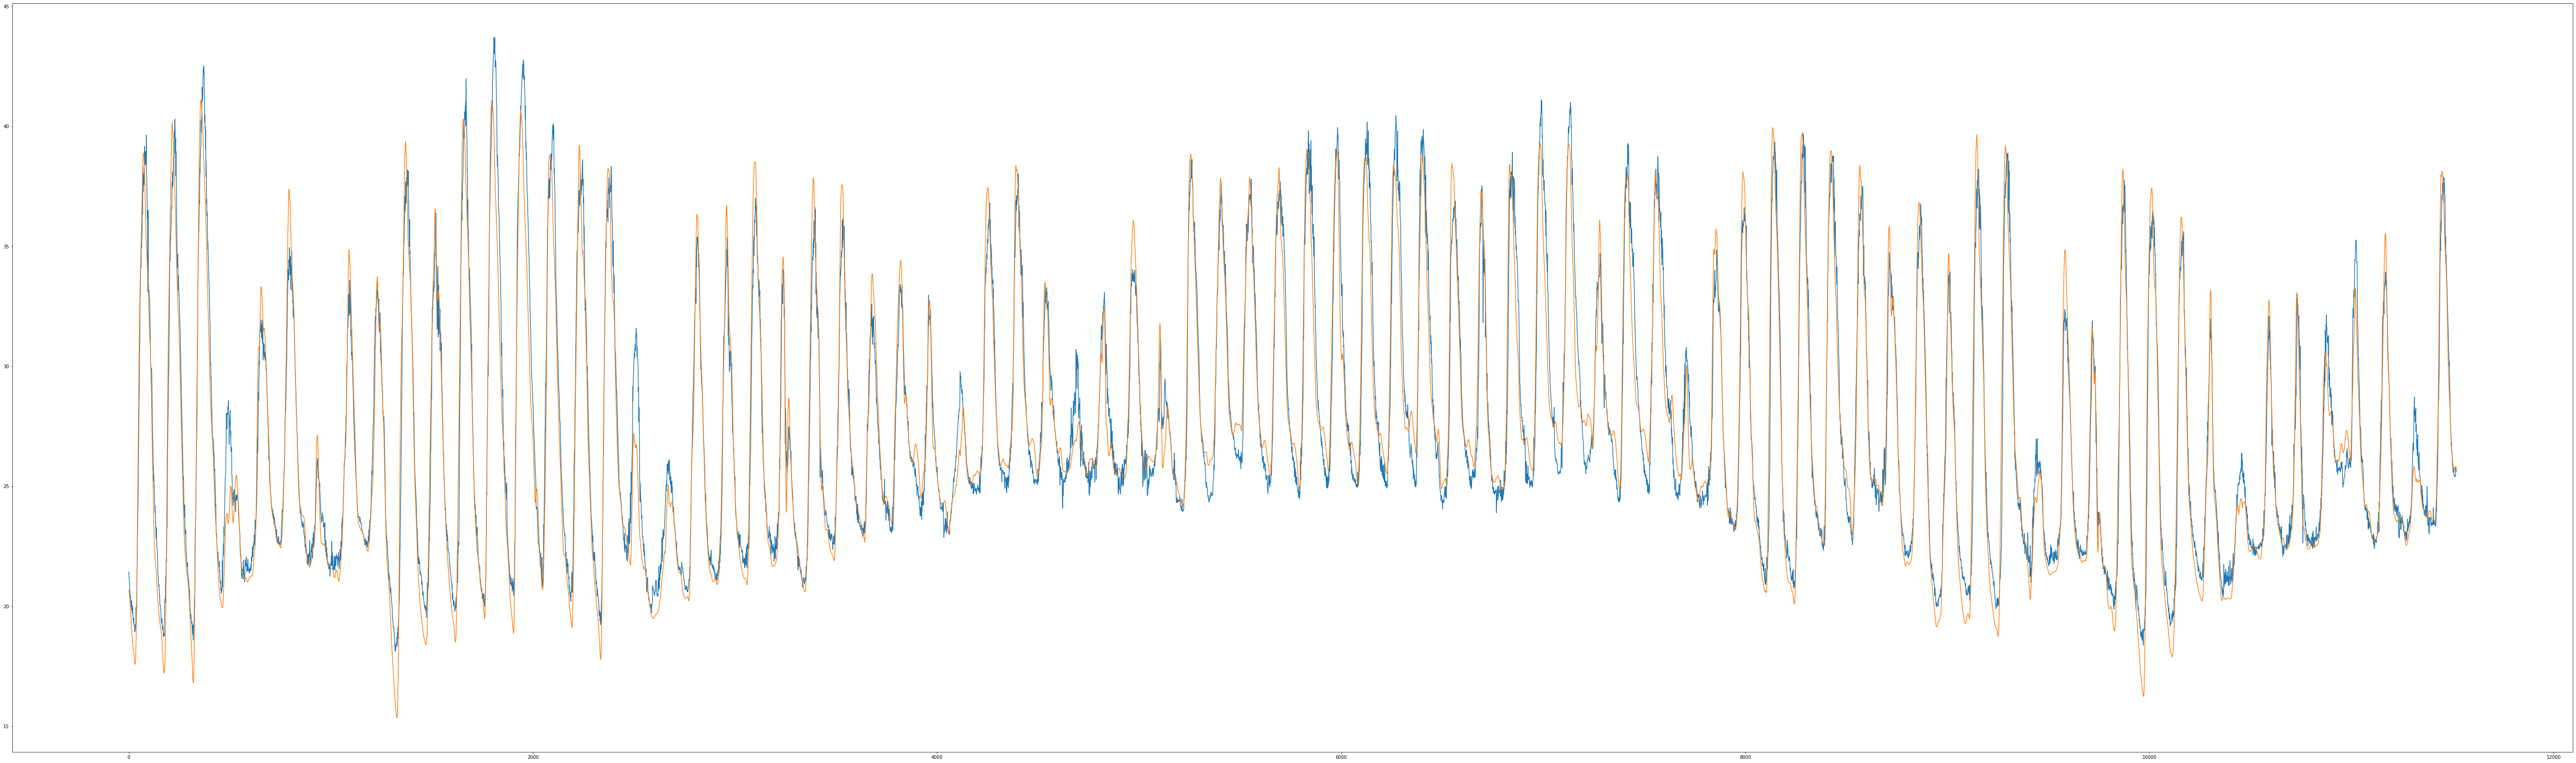

In [0]:
# 필터 적용 후 그래프

plt.figure(figsize=(100,30))
plt.plot(c.reset_index().iloc[:,-1:])
plt.plot(bestmodel.iloc[:,-1:])

In [0]:
f_df = pd.DataFrame(filtered, columns = ['Y18'])
f_df.index = test['id']

In [0]:
f_df.to_csv('/content/drive/My Drive/daycon/200413_hr_1.32.csv')